In [99]:
packageVersion('IRdisplay')
packageVersion('IRkernel')
packageVersion('repr')

[1] ‘0.4.9000’

[1] ‘0.6’

[1] ‘0.9’

In [100]:
clean_column <- function(col) {
    col <- sapply(col, function(x) toString(x))
    col <- sapply(col, function(x) tolower(x))
    col <- sapply(col, function(x) gsub("-", "", x))
    col <- sapply(col, function(x) gsub(" ", "", x))
    return(col)
}

In [177]:
payment_per_period <- function(principal_value, interest_rate, number_of_periods) {
    interest_rate * principal_value / (1 - (1 + interest_rate)^(-number_of_periods))
}

In [208]:
MAKES_WANTED = c("toyota", "honda", "chevrolet", "mazda", "nissan", "subaru", "hyundai")
MODELS_WANTED = c("rav4", "crv", "accord", "camry", "hrv", "4runner", "rogue", "murano", "santafe")
MIN_YEAR = 2010
MAX_KILOMETERS = 100000

# Parse and Clean Data

In [239]:
raw_df = rbind(
    read.csv("data/kijiji_cars.csv"), 
    read.csv("data/ottawahonda_cars.csv"),
    read.csv("data/tonygrahamtoyota_cars.csv"),
    read.csv("data/jimtubman_cars.csv")
)

raw_df$make <- clean_column(raw_df$make)
raw_df$model <- clean_column(raw_df$model)
    
raw_df$price <- as.character(raw_df$price)
raw_df$price <- lapply(raw_df$price, function(x) gsub("\\$", "", x))
raw_df$price <- lapply(raw_df$price, function(x) gsub("\\,", "", x))
raw_df$price <- as.numeric(raw_df$price)
    
raw_df$kilometers <- as.character(raw_df$kilometers)
raw_df$kilometers <- lapply(raw_df$kilometers, function(x) gsub("km", "", x))
raw_df$kilometers <- lapply(raw_df$kilometers, function(x) gsub(",", "", x))
raw_df$kilometers <- as.numeric(raw_df$kilometers)
    
raw_df$age <- 2016 - raw_df$year
    
raw_df <- raw_df[, !(names(raw_df) %in% c("description"))]

Warning message:
In `[<-.factor`(`*tmp*`, ri, value = c(173364, 86548, 41900, 23006, : invalid factor level, NA generatedWarning message:
In `[<-.factor`(`*tmp*`, ri, value = c(5, 5, 5, 5, 6, 5, 5, 10, : invalid factor level, NA generatedWarning message:
In `[<-.factor`(`*tmp*`, ri, value = c(30279L, 53883L, 34243L, 27971L, : invalid factor level, NA generatedWarning message:
In eval(expr, envir, enclos): NAs introduced by coercionWarning message:
In eval(expr, envir, enclos): NAs introduced by coercionWarning message:
In eval(expr, envir, enclos): NAs introduced by coercionWarning message:
In eval(expr, envir, enclos): NAs introduced by coercionWarning message:
In eval(expr, envir, enclos): NAs introduced by coercionWarning message:
In eval(expr, envir, enclos): NAs introduced by coercionWarning message:
In eval(expr, envir, enclos): NAs introduced by coercionWarning message:
In eval(expr, envir, enclos): NAs introduced by coercionWarning message:
In eval(expr, envir, enclos): NAs int

## Add Loan Data 

In [211]:
raw_df$sales_tax <- raw_df$price * 0.15
raw_df$total_price <- raw_df$price + raw_df$sales_tax
    
raw_df$five_yr_six_prcnt_monthly <- lapply(raw_df$total_price, function(x) payment_per_period(x, 0.06 / 12, 60))
raw_df$three_yr_six_prcnt_monthly <- lapply(raw_df$total_price, function(x) payment_per_period(x, 0.06 / 12, 36))
raw_df$five_yr_one_prcnt_monthly <- lapply(raw_df$total_price, function(x) payment_per_period(x, 0.01 / 12, 60))
raw_df$three_yr_one_prcnt_monthly <- lapply(raw_df$total_price, function(x) payment_per_period(x, 0.01 / 12, 36))

In [213]:
colnames(raw_df)

[1] "domain"                     "date_listed"               
 [3] "url"                        "make"                      
 [5] "title"                      "year"                      
 [7] "kilometers"                 "model"                     
 [9] "price"                      "age"                       
[11] "sales_tax"                  "total_price"               
[13] "five_yr_six_prcnt_monthly"  "three_yr_six_prcnt_monthly"
[15] "five_yr_one_prcnt_monthly"  "three_yr_one_prcnt_monthly"

## Filter Down to Desired

In [215]:
raw_df <- raw_df[raw_df$make %in% MAKES_WANTED, ]
raw_df <- raw_df[raw_df$kilometers < MAX_KILOMETERS, ]
raw_df <- raw_df[raw_df$year > MIN_YEAR, ]
nrow(raw_df)

[1] 295

## Rename

In [240]:
df <- raw_df

## Join with Fuel and Maintenance Data

In [241]:
eff <- read.csv("data/nrcan_fuel_ratings.csv")
nrow(eff)

[1] 44152

In [226]:
eff <- eff[!duplicated(eff$title), ]
eff$make <- clean_column(eff$make)
eff$model <- clean_column(eff$model)
nrow(eff)
colnames(eff)

[1] 2380

[1] "engine_size_litres"       "domain"                  
 [3] "cylinders"                "title"                   
 [5] "transmission"             "year"                    
 [7] "make"                     "ranking_overall"         
 [9] "lphkm_city"               "ranking_class"           
[11] "lphkm_hwy"                "url"                     
[13] "model_class"              "fuel"                    
[15] "estimated_fuel_cost_year" "model"

In [227]:
library(dplyr)
df <- dplyr::left_join(
    df, 
    eff, 
    by=c("make" = "make", "model" = "model", "year" = "year")
)  
nrow(df)
colnames(df)

ERROR: Error in eval(expr, envir, enclos): Can't join on 'year' x 'year' because of incompatible types (factor / integer)


In [228]:
maintenance <- read.csv("data/maintenance_costs_manual_collection.csv")
maintenance$make <- clean_column(maintenance$make)
maintenance$model <- clean_column(maintenance$model)
nrow(maintenance)
colnames(maintenance)

[1] 14

[1] "make"                    "model"                  
 [3] "year"                    "five_year_maintenance"  
 [5] "eight_year_maintenance"  "five_year_depreciation" 
 [7] "eight_year_depreciation" "five_year_fuel"         
 [9] "msrp_lower"              "msrp_upper"             
[11] "predicted_reliability"

In [229]:
df <- left_join(
    df, 
    maintenance, 
    by=c("make" = "make", "model" = "model", "year" = "year")
)  
nrow(df)
colnames(df)

[1] 295

[1] "domain"                     "date_listed"               
 [3] "url"                        "make"                      
 [5] "title"                      "year"                      
 [7] "kilometers"                 "model"                     
 [9] "price"                      "age"                       
[11] "sales_tax"                  "total_price"               
[13] "five_yr_six_prcnt_monthly"  "three_yr_six_prcnt_monthly"
[15] "five_yr_one_prcnt_monthly"  "three_yr_one_prcnt_monthly"
[17] "five_year_maintenance"      "eight_year_maintenance"    
[19] "five_year_depreciation"     "eight_year_depreciation"   
[21] "five_year_fuel"             "msrp_lower"                
[23] "msrp_upper"                 "predicted_reliability"

In [230]:
summary(df$kilometers)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
      1   31800   56380   52760   71790   96520     197 

# Overview

Warning message:
: Removed 204 rows containing missing values (geom_point).

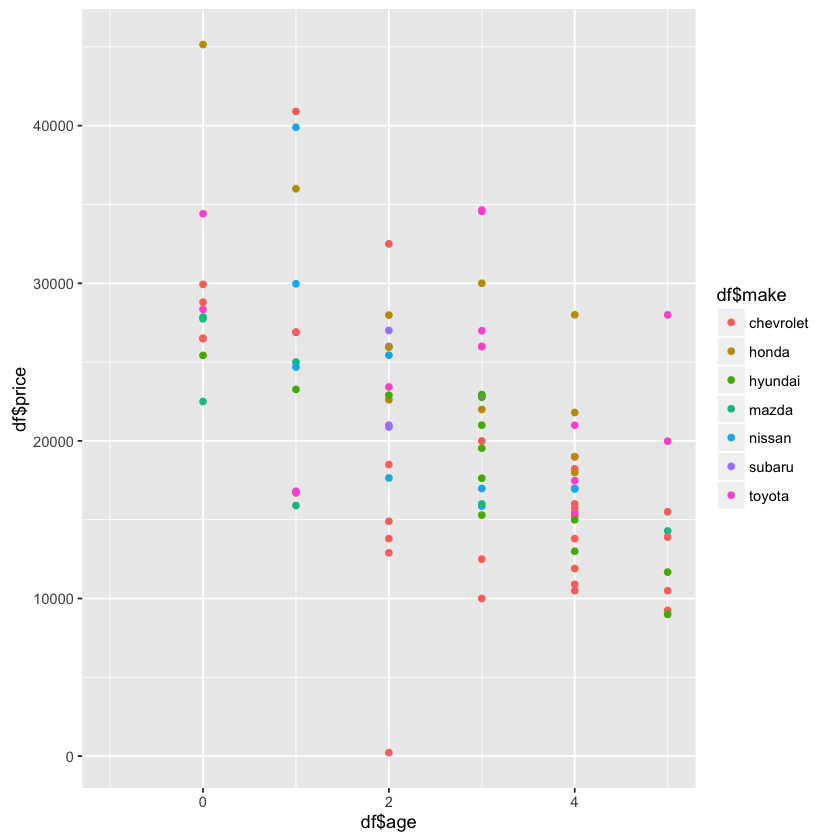

In [236]:
library(ggplot2)
ggplot(df) + geom_point(aes(x=df$age, y=df$price, colour=df$make))

# Toyota

In [237]:
library(ggplot2)
plot_price_vs_age <- function(dataframe) {
    p <- ggplot(dataframe, aes(age, price, label=model, color=domain.x))
    p + geom_label() + ggtitle("price vs age")  
}
tmp <- df[df$make == "toyota", ]
plot_price_vs_age(tmp)

ERROR: Error in file(con, "rb"): cannot open the connection


plot without title

In [233]:
colnames(df)


[1] "domain"                     "date_listed"               
 [3] "url"                        "make"                      
 [5] "title"                      "year"                      
 [7] "kilometers"                 "model"                     
 [9] "price"                      "age"                       
[11] "sales_tax"                  "total_price"               
[13] "five_yr_six_prcnt_monthly"  "three_yr_six_prcnt_monthly"
[15] "five_yr_one_prcnt_monthly"  "three_yr_one_prcnt_monthly"
[17] "five_year_maintenance"      "eight_year_maintenance"    
[19] "five_year_depreciation"     "eight_year_depreciation"   
[21] "five_year_fuel"             "msrp_lower"                
[23] "msrp_upper"                 "predicted_reliability"

In [234]:
plot_price_vs_kilometers <- function(dataframe) {
    dataframe <- dataframe[dataframe$kilometers < 200000, ]
    p <- ggplot(dataframe, aes(kilometers, price, label=model, color=domain.x))
    p <- p + geom_label() + ggtitle("price vs kilometers")
    p
}
tmp <- df[df$make == "toyota", ]
plot_price_vs_kilometers(tmp)

ERROR: Error in file(con, "rb"): cannot open the connection


plot without title

# Honda

Warning message:
: Removed 3 rows containing missing values (geom_label).

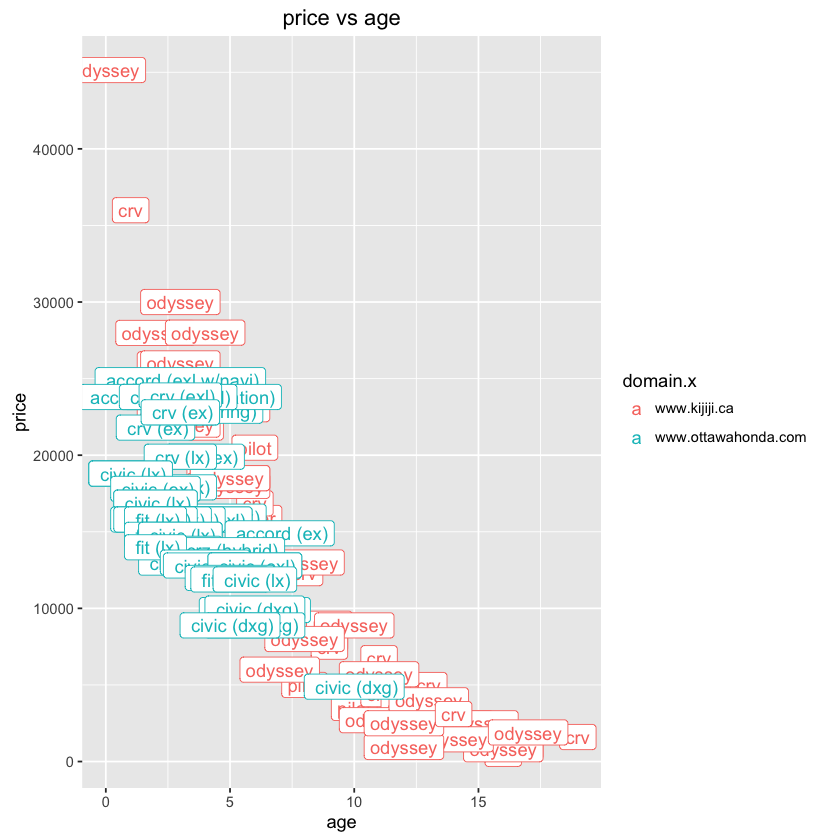

In [139]:
tmp <- df[df$make == "honda", ]
plot_price_vs_age(tmp)

Warning message:
: Removed 51 rows containing missing values (geom_label).

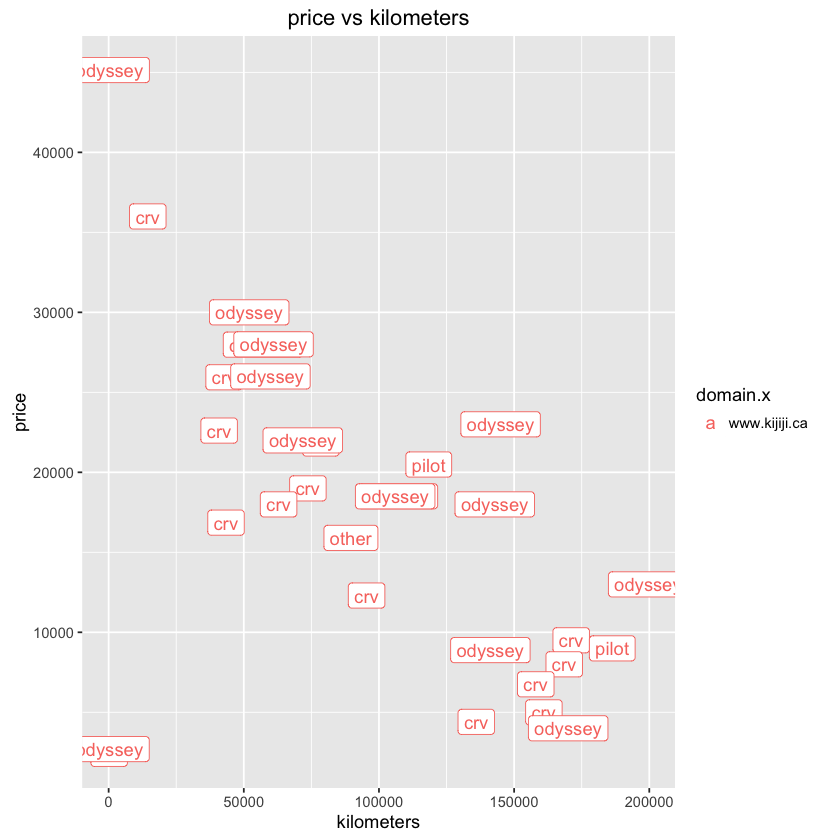

In [140]:
tmp <- df[df$make == "honda", ]
plot_price_vs_kilometers(tmp)

In [141]:
write.csv(df, file="data/output.csv")